In [1]:
import pandas as pd
data_path = "/media/bokey/HDD_internal_500G1/open_source_projects/sapeint NER/ner dataset/data/ner_dataset.csv"
df = pd.read_csv(data_path, encoding="latin-1")
df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")
sentences = df.groupby("Sentence #")["Word"].apply(list).values
pos = df.groupby("Sentence #")["POS"].apply(list).values
tags = df.groupby("Sentence #")["Tag"].apply(list).values

Experimenting with model: en_core_web_sm


100%|█████████▉| 3835/3836.625 [02:21<00:00, 27.04it/s]/home/bokey/anaconda3/envs/auto_ner/lib/python3.10/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 3837/3836.625 [02:21<00:00, 27.03it/s]
100%|██████████| 3837/3836.625 [02:21<00:00, 27.07it/s]


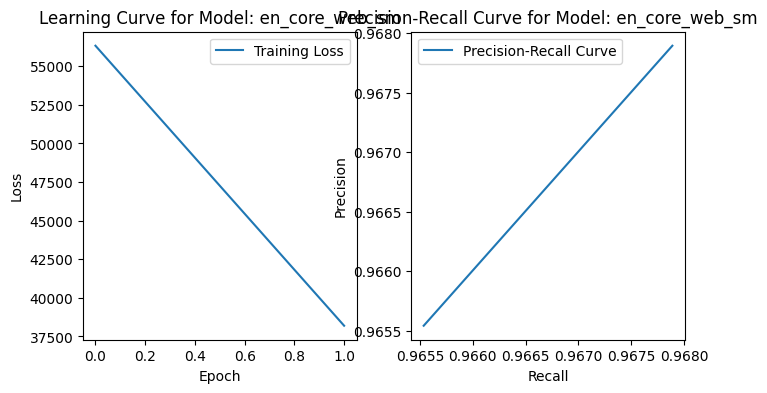

Trained model saved as: en_core_web_sm_ner_model_2023-08-29_17-07-42
Experimenting with model: en_core_web_md


100%|██████████| 3837/3836.625 [02:29<00:00, 25.65it/s]
100%|██████████| 3837/3836.625 [02:32<00:00, 25.14it/s]


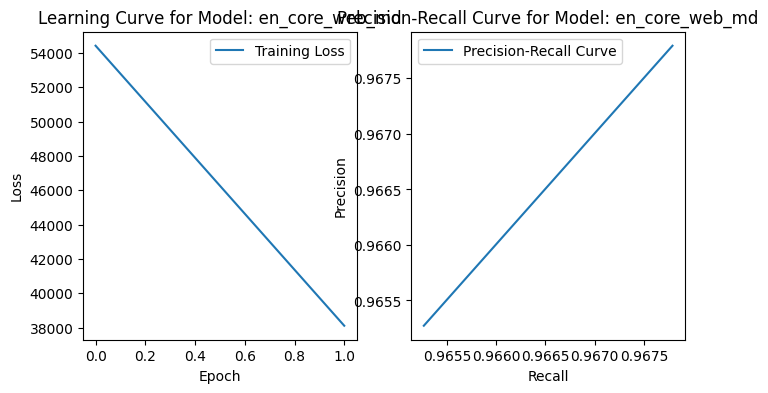

Trained model saved as: en_core_web_md_ner_model_2023-08-29_17-13-36
Experimenting with model: en_core_web_lg


100%|██████████| 3837/3836.625 [02:30<00:00, 25.44it/s]
100%|██████████| 3837/3836.625 [02:30<00:00, 25.48it/s]


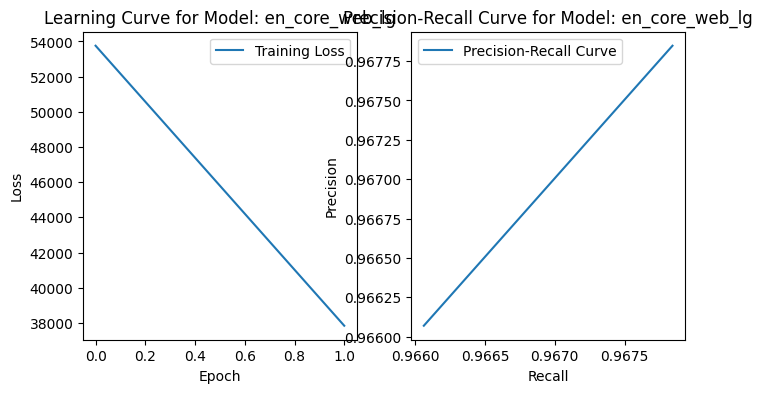

Trained model saved as: en_core_web_lg_ner_model_2023-08-29_17-19-30
Model: en_core_web_sm
ents_p: 0.967895733007499
ents_r: 0.9678899357319549
ents_f: 0.9678928343610461
ents_per_type: {'O': {'p': 0.9906130416704839, 'r': 0.9924875203874858, 'f': 0.9915493951257361}, 'B-geo': {'p': 0.8344105878731918, 'r': 0.9042695130086724, 'f': 0.8679366095725949}, 'B-gpe': {'p': 0.9473254389546754, 'r': 0.9446254071661238, 'f': 0.945973496432212}, 'B-per': {'p': 0.8652050345107593, 'r': 0.7791590493601462, 'f': 0.819930742593305}, 'I-per': {'p': 0.80521520578071, 'r': 0.9354014598540146, 'f': 0.8654398109066351}, 'B-tim': {'p': 0.88, 'r': 0.8989247311827957, 'f': 0.8893617021276596}, 'B-nat': {'p': 0.5714285714285714, 'r': 0.42105263157894735, 'f': 0.48484848484848486}, 'B-org': {'p': 0.8145161290322581, 'r': 0.6759082217973231, 'f': 0.7387669801462905}, 'I-tim': {'p': 0.8689839572192514, 'r': 0.6310679611650486, 'f': 0.7311586051743533}, 'I-geo': {'p': 0.7111269614835949, 'r': 0.8185550082101807,

In [15]:
import spacy
import random
from spacy.training.example import Example
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from spacy.tokens import Doc
from tqdm import tqdm
import datetime
# Assuming you have the 'sentences' and 'tags' lists

# Split data into training, validation, and test sets
train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, tags, test_size=0.2, random_state=42)
train_sentences, val_sentences, train_tags, val_tags = train_test_split(train_sentences, train_tags, test_size=0.2, random_state=42)

# Define hyperparameters for training
learning_rate = 0.001
n_iter = 2
dropout = 0.5

# Define a directory to save models
model_save_dir = "saved_models/"

# Experiment with different spaCy models
model_names = ["en_core_web_sm", "en_core_web_md", "en_core_web_lg"]

# Lists to store evaluation metrics
ner_metrics = []

def convert_to_spacy_format(sentences, tags):
    examples = []
    for sent, tag_list in zip(sentences, tags):
        words = sent
        spaces = [True] * len(words)
        doc = Doc(nlp.vocab, words=words, spaces=spaces)
        gold_entities = []
        for token, tag in zip(doc, tag_list):
            start = token.idx
            end = start + len(token.text)
            gold_entities.append((start, end, tag))
        example = Example.from_dict(doc, {"entities": gold_entities})
        examples.append(example)
    return examples

for model_name in model_names:
    print(f"Experimenting with model: {model_name}")
    
    # Load the pre-trained model
    nlp = spacy.load(model_name)

    # Add or modify the NER component in the pipeline
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner")
    else:
        ner = nlp.get_pipe("ner")

    # Add entity labels to the ner component
    for label in set(tag for tag_list in tags for tag in tag_list):
        ner.add_label(label)

    # Create spaCy examples for training
    train_examples = convert_to_spacy_format(train_sentences, train_tags)
    val_examples = convert_to_spacy_format(val_sentences, val_tags)
    test_examples = convert_to_spacy_format(test_sentences, test_tags)

    # Lists to store learning curve data
    train_losses = []
    val_precisions = []
    val_recalls = []

    # Train the NER model
    for epoch in range(n_iter):
        random.shuffle(train_examples)
        losses = {}
        for batch in tqdm(spacy.util.minibatch(train_examples, size=8), total = len(train_examples)/8):
            nlp.update(batch, drop=dropout, losses=losses)
        train_losses.append(losses["ner"])

        # Evaluate the model on the validation set
        metrics = nlp.evaluate(val_examples)
        val_precisions.append(metrics["ents_p"])
        val_recalls.append(metrics["ents_r"])

    # Append metrics to the ner_metrics list
    ner_metrics.append(metrics)

    # Plot learning curve
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(range(n_iter), train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve for Model: {model_name}")
    plt.legend()

    # Plot Precision-Recall curve
    plt.subplot(1, 3, 2)
    plt.plot(val_recalls, val_precisions, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for Model: {model_name}")
    plt.legend()

    plt.show()

    # Save the trained model to disk with timestamp
    current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_model_name = f"{model_name}_ner_model_{current_time}"
    nlp.to_disk(model_save_dir + save_model_name)
    print(f"Trained model saved as: {save_model_name}")

# Print important NER performance metrics
ner_performance_metrics = ["ents_p", "ents_r", "ents_f", "ents_per_type"]

for model_name, metrics in zip(model_names, ner_metrics):
    print(f"Model: {model_name}")
    for metric_name in ner_performance_metrics:
        metric_value = metrics.get(metric_name, 0.0)  # Use 0.0 if metric is not present
        print(f"{metric_name}: {metric_value}")
    print()

In [14]:
# Print important NER performance metrics
ner_performance_metrics = ["ents_p", "ents_r", "ents_f", "ents_per_type"]

for model_name, metrics in zip(model_names, ner_metrics):
    print(f"Model: {model_name}")
    for metric_name in ner_performance_metrics:
        metric_value = metrics.get(metric_name, 0.0)  # Use 0.0 if metric is not present
        print(f"{metric_name}: {metric_value}")
    print()


Model: en_core_web_sm
ents_p: 0.9677699513644313
ents_r: 0.9677641548422647
ents_f: 0.9677670530946684
ents_per_type: {'O': {'p': 0.9915044772746533, 'r': 0.9913154605983153, 'f': 0.9914099599272689}, 'B-geo': {'p': 0.843164576559839, 'r': 0.9082721814543029, 'f': 0.874508229626656}, 'B-gpe': {'p': 0.9602344077019673, 'r': 0.9340390879478827, 'f': 0.9469556243550051}, 'B-per': {'p': 0.7916381082933516, 'r': 0.8446069469835467, 'f': 0.8172651689368475}, 'I-per': {'p': 0.7954615148727384, 'r': 0.9467153284671533, 'f': 0.8645225795700716}, 'B-tim': {'p': 0.9222695965890456, 'r': 0.8639016897081413, 'f': 0.8921319796954315}, 'B-org': {'p': 0.7931674712216858, 'r': 0.6806883365200764, 'f': 0.7326359115074601}, 'I-tim': {'p': 0.8412887828162291, 'r': 0.6844660194174758, 'f': 0.7548179871520343}, 'I-geo': {'p': 0.8571428571428571, 'r': 0.6995073891625616, 'f': 0.7703435804701627}, 'I-org': {'p': 0.7354243542435425, 'r': 0.7949740725967291, 'f': 0.764040636381062}, 'B-eve': {'p': 0.71428571428

In [12]:
ner_metrics[0]

{'token_acc': 1.0,
 'token_p': 1.0,
 'token_r': 1.0,
 'token_f': 1.0,
 'tag_acc': None,
 'sents_p': 1.0,
 'sents_r': 1.0,
 'sents_f': 1.0,
 'dep_uas': None,
 'dep_las': None,
 'dep_las_per_type': None,
 'pos_acc': None,
 'morph_acc': None,
 'morph_micro_p': None,
 'morph_micro_r': None,
 'morph_micro_f': None,
 'morph_per_feat': None,
 'lemma_acc': None,
 'ents_p': 0.9677699513644313,
 'ents_r': 0.9677641548422647,
 'ents_f': 0.9677670530946684,
 'ents_per_type': {'O': {'p': 0.9915044772746533,
   'r': 0.9913154605983153,
   'f': 0.9914099599272689},
  'B-geo': {'p': 0.843164576559839,
   'r': 0.9082721814543029,
   'f': 0.874508229626656},
  'B-gpe': {'p': 0.9602344077019673,
   'r': 0.9340390879478827,
   'f': 0.9469556243550051},
  'B-per': {'p': 0.7916381082933516,
   'r': 0.8446069469835467,
   'f': 0.8172651689368475},
  'I-per': {'p': 0.7954615148727384,
   'r': 0.9467153284671533,
   'f': 0.8645225795700716},
  'B-tim': {'p': 0.9222695965890456,
   'r': 0.8639016897081413,
   '

In [11]:
import spacy
import random
from spacy.training.example import Example
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from spacy.tokens import Doc
# from spacy.util import align_tokens
from tqdm import tqdm

# Assuming you have the 'sentences' and 'tags' lists

# Split data into training, validation, and test sets
train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, tags, test_size=0.2, random_state=42)
train_sentences, val_sentences, train_tags, val_tags = train_test_split(train_sentences, train_tags, test_size=0.2, random_state=42)

# Define hyperparameters for training
learning_rate = 0.001
n_iter = 10
dropout = 0.5

# Experiment with different spaCy models
model_names = ["en_core_web_sm", "en_core_web_md", "en_core_web_lg"]

# Lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

def convert_to_spacy_format(sentences, tags):
    examples = []
    for sent, tag_list in zip(sentences, tags):
        words = sent
        spaces = [True] * len(words)
        doc = Doc(nlp.vocab, words=words, spaces=spaces)
        gold_entities = []
        for token, tag in zip(doc, tag_list):
            start = token.idx
            end = start + len(token.text)
            gold_entities.append((start, end, tag))
        example = Example.from_dict(doc, {"entities": gold_entities})
        examples.append(example)
    return examples

for model_name in model_names:
    print(f"Experimenting with model: {model_name}")
    
    # Load the pre-trained model
    nlp = spacy.load(model_name)

    # Add or modify the NER component in the pipeline
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner")
    else:
        ner = nlp.get_pipe("ner")

    # Add entity labels to the ner component
    for label in set(tag for tag_list in tags for tag in tag_list):
        ner.add_label(label)

    # Create spaCy examples for training
    train_examples = convert_to_spacy_format(train_sentences, train_tags)
    val_examples = convert_to_spacy_format(val_sentences, val_tags)
    test_examples = convert_to_spacy_format(test_sentences, test_tags)

    # Lists to store learning curve data
    train_losses = []
    val_f1_scores = []

    # Train the NER model
    for epoch in range(n_iter):
        random.shuffle(train_examples)
        losses = {}
        for batch in tqdm(spacy.util.minibatch(train_examples, size=8), total = len(train_examples)/8):
            nlp.update(batch, drop=dropout, losses=losses)
        train_losses.append(losses["ner"])

        # Evaluate the model on the validation set
        with nlp.disable_pipes("ner"):
            val_f1 = nlp.evaluate(val_examples)
            val_f1_scores.append(val_f1)


    # Plot learning curve
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(range(n_iter), train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve for Model: {model_name}")
    plt.legend()

    # Plot F1-score curve
    plt.subplot(1, 3, 2)
    plt.plot(range(n_iter), val_f1_scores, label="Validation F1-score")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.title(f"F1-score Curve for Model: {model_name}")
    plt.legend()


# Print evaluation metrics
for model_name, accuracy, precision, recall, f1 in zip(model_names, accuracy_scores, precision_scores, recall_scores, f1_scores):
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print()


Experimenting with model: en_core_web_sm


100%|█████████▉| 3836/3836.625 [02:23<00:00, 26.17it/s]/home/bokey/anaconda3/envs/auto_ner/lib/python3.10/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 3837/3836.625 [02:23<00:00, 26.71it/s]


KeyError: 'ents_f'

In [18]:
val_f1_scores

[{'token_acc': 1.0,
  'token_p': 1.0,
  'token_r': 1.0,
  'token_f': 1.0,
  'tag_acc': None,
  'sents_p': 1.0,
  'sents_r': 1.0,
  'sents_f': 1.0,
  'dep_uas': None,
  'dep_las': None,
  'dep_las_per_type': None,
  'pos_acc': None,
  'morph_acc': None,
  'morph_micro_p': None,
  'morph_micro_r': None,
  'morph_micro_f': None,
  'morph_per_feat': None,
  'lemma_acc': None,
  'speed': 23770.9322669704},
 {'token_acc': 1.0,
  'token_p': 1.0,
  'token_r': 1.0,
  'token_f': 1.0,
  'tag_acc': None,
  'sents_p': 1.0,
  'sents_r': 1.0,
  'sents_f': 1.0,
  'dep_uas': None,
  'dep_las': None,
  'dep_las_per_type': None,
  'pos_acc': None,
  'morph_acc': None,
  'morph_micro_p': None,
  'morph_micro_r': None,
  'morph_micro_f': None,
  'morph_per_feat': None,
  'lemma_acc': None,
  'speed': 24091.44695780155},
 {'token_acc': 1.0,
  'token_p': 1.0,
  'token_r': 1.0,
  'token_f': 1.0,
  'tag_acc': None,
  'sents_p': 1.0,
  'sents_r': 1.0,
  'sents_f': 1.0,
  'dep_uas': None,
  'dep_las': None,
  'd

In [17]:
print(y_true.shape)
print(y_pred.shape)

(166957, 3)
(0,)


In [2]:
import spacy
import random
from spacy.training.example import Example
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
# Assuming you have the 'sentences' and 'tags' lists

# Split data into training, validation, and test sets
train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, tags, test_size=0.2, random_state=42)
train_sentences, val_sentences, train_tags, val_tags = train_test_split(train_sentences, train_tags, test_size=0.2, random_state=42)

# Define hyperparameters for training
learning_rate = 0.001
n_iter = 2
dropout = 0.5

# Experiment with different spaCy models
model_names = ["en_core_web_sm", "en_core_web_md", "en_core_web_lg"]

# Lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

def convert_to_spacy_format(sentences, tags):
    examples = []
    for sent, tag_list in zip(sentences, tags):
        doc = spacy.tokens.Doc(nlp.vocab, words=sent)
        entities = []
        for token, tag in zip(doc, tag_list):
            label = tag
            start = token.idx
            end = start + len(token.text)
            entities.append((start, end, label))
        example = Example.from_dict(doc, {"entities": entities})
        examples.append(example)
    return examples

for model_name in model_names:
    print(f"Experimenting with model: {model_name}")
    
    # Load the pre-trained model
    nlp = spacy.load(model_name)

    # Add or modify the NER component in the pipeline
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner")
    else:
        ner = nlp.get_pipe("ner")

    # Add entity labels to the ner component
    for label in set(tag for tag_list in tags for tag in tag_list):
        ner.add_label(label)

    # Create spaCy examples for training
    train_examples = convert_to_spacy_format(train_sentences, train_tags)
    val_examples = convert_to_spacy_format(val_sentences, val_tags)
    test_examples = convert_to_spacy_format(test_sentences, test_tags)

    # Lists to store learning curve data
    train_losses = []
    val_scores = []

    # Train the NER model
    for epoch in range(n_iter):
        random.shuffle(train_examples)
        losses = {}
        for batch in tqdm(spacy.util.minibatch(train_examples, size=8), total = len(train_examples) / 8):
            nlp.update(batch, drop=dropout, losses=losses)
        train_losses.append(losses["ner"])

        # Evaluate the model on the validation set
        with nlp.disable_pipes("ner"):
            val_f1 = nlp.evaluate(val_examples)
            val_scores.append(val_f1)

    # Calculate evaluation metrics
    y_true = []
    y_pred = []
    for example in val_examples:
        doc = example.reference
        gold_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        y_true.extend(gold_entities)
        pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in nlp(doc.text).ents]
        y_pred.extend(pred_entities)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    # Append scores to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Plot learning curve
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(range(n_iter), train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve for Model: {model_name}")
    plt.legend()

    # Create Confusion Matrix
    plt.subplot(1, 3, 3)
    labels = list(set(tag for tag_list in tags for tag in tag_list))
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.tight_layout()

    plt.show()

    break

# Print evaluation metrics
for model_name, accuracy, precision, recall, f1 in zip(model_names, accuracy_scores, precision_scores, recall_scores, f1_scores):
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print()


Experimenting with model: en_core_web_sm


100%|█████████▉| 3835/3836.625 [02:22<00:00, 27.07it/s]/home/bokey/anaconda3/envs/auto_ner/lib/python3.10/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 3837/3836.625 [02:22<00:00, 26.93it/s]
100%|██████████| 3837/3836.625 [02:22<00:00, 26.88it/s]


ValueError: Found input variables with inconsistent numbers of samples: [166957, 170472]

In [3]:
# Calculate evaluation metrics
y_true = []
y_pred = []
for example in val_examples:
    doc = example.reference
    gold_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    y_true.extend(gold_entities)
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in nlp(doc.text).ents]
    y_pred.extend(pred_entities)
    if len(gold_entities) != len(pred_entities):
        print("count mistach for ex:", example)
        break

# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

count mistach for ex: {'doc_annotation': {'cats': {}, 'entities': ['U-O', 'U-O', 'U-O', 'U-O', 'U-B-org', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-B-org', 'U-O', 'U-B-per', 'U-I-per', 'U-I-per', 'U-O', 'U-O', 'U-O', 'U-O', 'U-B-tim', 'U-I-tim', 'U-I-tim', 'U-I-tim', 'U-O', 'U-O', 'U-O', 'U-O', 'U-B-geo'], 'spans': {}, 'links': {}}, 'token_annotation': {'ORTH': ['U.S.-led', 'forces', 'toppled', 'the', 'Taleban', 'government', 'after', 'it', 'refused', 'to', 'hand', 'over', 'al-Qaida', 'leader', 'Osama', 'bin', 'Laden', ',', 'architect', 'of', 'the', 'September', '11', ',', '2001', ',', 'attacks', 'against', 'the', 'U.S.'], 'SPACY': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True], 'TAG': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'LEMMA': ['', '', '', '', '', '', '', '

In [8]:
print(len(doc))
print(len(gold_entities))
print(len(pred_entities))

30
30
32


In [121]:
print(len(doc))
print(len(sent))
print(len(entities))

32
30
30


In [122]:
print(len(tag_list))

30


In [11]:
import spacy
import random
from spacy.training.example import Example
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
# Assuming you have the 'sentences' and 'tags' lists
# Split data into training, validation, and test sets

# Load the pre-trained model
nlp = spacy.load("en_core_web_sm")

# Add or modify the NER component in the pipeline
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# Add entity labels to the ner component
for label in set(tag for tag_list in tags for tag in tag_list):
    ner.add_label(label)

train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, tags, test_size=0.2, random_state=42)
train_sentences, val_sentences, train_tags, val_tags = train_test_split(train_sentences, train_tags, test_size=0.2, random_state=42)

examples = []
for sent, tag_list in zip(sentences, tags):
    doc = nlp.make_doc(" ".join(sent))
    entities = []
    for token, tag in zip(doc, tag_list):
        label = tag
        start = token.idx
        end = start + len(token.text)
        entities.append((start, end, label))
    example = Example.from_dict(doc, {"entities": entities})
    examples.append(example)
    if len(doc) != len(entities):
        print("this example have count mismatch")
        print(len(doc))
        print(len(entities))
        break

# val_examples = examples

# # Calculate evaluation metrics
# y_true = []
# y_pred = []
# for i, example in enumerate(val_examples):
#     doc = example.reference
#     gold_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
#     y_true.extend(gold_entities)
#     pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in nlp(doc.text).ents]
#     y_pred.extend(pred_entities)
#     if len(gold_entities) != len(pred_entities):
#         print("this is the xample with ount mismaytch:", i)
#         break

this example have count mismatch
13
11


In [16]:
print(sent)
example_dict =  {'doc_annotation': {'cats': {}, 'entities': ['U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'O', 'O'], 'spans': {}, 'links': {}}, 'token_annotation': {'ORTH': ['They', 'left', 'after', 'a', 'tense', 'hour', '-', 'long', 'standoff', 'with', 'riot', 'police', '.'], 'SPACY': [True, True, True, True, True, False, False, True, True, True, True, True, False], 'TAG': ['', '', '', '', '', '', '', '', '', '', '', '', ''], 'LEMMA': ['', '', '', '', '', '', '', '', '', '', '', '', ''], 'POS': ['', '', '', '', '', '', '', '', '', '', '', '', ''], 'MORPH': ['', '', '', '', '', '', '', '', '', '', '', '', ''], 'HEAD': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'DEP': ['', '', '', '', '', '', '', '', '', '', '', '', ''], 'SENT_START': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}
print(example_dict['token_annotation']['ORTH'])

['They', 'left', 'after', 'a', 'tense', 'hour-long', 'standoff', 'with', 'riot', 'police', '.']
['They', 'left', 'after', 'a', 'tense', 'hour', '-', 'long', 'standoff', 'with', 'riot', 'police', '.']


In [102]:


doc = nlp.make_doc(" ".join(val_sentences[2]))

entities = []
for token, tag in zip(doc, val_tags[2]):
    label = tag
    start = token.idx
    end = start + len(token.text)
    entities.append((start, end, label))
example = Example.from_dict(doc, {"entities": entities})
if len(doc) != len(entities):
    print("this example have count mismatch")
    print(len(doc))
    print(len(entities))


this example have count mismatch
32
30


In [105]:
print(len(val_tags[2]))

30


In [98]:
example_diact = {'doc_annotation': {'cats': {}, 'entities': ['U-O', 'U-O', 'U-O', 'U-O', 'U-B-org', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-O', 'U-B-org', 'U-O', 'U-B-per', 'U-I-per', 'U-I-per', 'U-O', 'U-O', 'U-O', 'U-O', 'U-B-tim', 'U-I-tim', 'U-I-tim', 'U-I-tim', 'U-O', 'U-O', 'U-O', 'U-O', 'U-B-geo', 'O', 'O'], 'spans': {}, 'links': {}}, 'token_annotation': {'ORTH': ['U.S.-led', 'forces', 'toppled', 'the', 'Taleban', 'government', 'after', 'it', 'refused', 'to', 'hand', 'over', 'al', '-', 'Qaida', 'leader', 'Osama', 'bin', 'Laden', ',', 'architect', 'of', 'the', 'September', '11', ',', '2001', ',', 'attacks', 'against', 'the', 'U.S.'], 'SPACY': [True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False], 'TAG': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'LEMMA': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'POS': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'MORPH': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'HEAD': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 'DEP': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'SENT_START': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}}
len(example_diact['doc_annotation']['entities'])

32

In [132]:
print(example_diact['token_annotation']['ORTH'])
print(sent)

['U.S.-led', 'forces', 'toppled', 'the', 'Taleban', 'government', 'after', 'it', 'refused', 'to', 'hand', 'over', 'al', '-', 'Qaida', 'leader', 'Osama', 'bin', 'Laden', ',', 'architect', 'of', 'the', 'September', '11', ',', '2001', ',', 'attacks', 'against', 'the', 'U.S.']
['The', 'Kurdish', 'party', 'has', 'fought', 'for', 'decades', 'for', 'the', 'creation', 'of', 'an', 'independent', 'Kurdish', 'state', 'in', 'southeastern', 'Turkey', ',', 'at', 'a', 'cost', 'of', 'at', 'least', '30,000', 'lives', '.']


In [9]:
# Calculate evaluation metrics
y_true = []
y_pred = []
for example in val_examples:
    doc = example.reference
    gold_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    y_true.extend(gold_entities)
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in nlp(doc.text).ents]
    y_pred.extend(pred_entities)
    if len(gold_entities) != len(pred_entities):
        print("for this recod in validation there count mistach")
        break

y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

# Append scores to lists
accuracy_scores.append(accuracy)
precision_scores.append(precision)
recall_scores.append(recall)
f1_scores.append(f1)

# Plot learning curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(range(n_iter), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Learning Curve for Model: {model_name}")
plt.legend()

# Create Confusion Matrix
plt.subplot(1, 3, 3)
labels = list(set(tag for tag_list in tags for tag in tag_list))
conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
plt.tight_layout()

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [166957, 169744]

In [21]:
# Calculate evaluation metrics
y_true = []
y_pred = []
for example in val_examples:
    doc = example.reference
    gold_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    y_true.extend(gold_entities)
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in nlp(doc.text).ents]
    y_pred.extend(pred_entities)
    if len(gold_entities) != len(pred_entities):
        print("for this recod in validation there count mistach")
        break

for this recod in validation there count mistach


In [28]:
print(doc)
print(gold_entities)
print(pred_entities)
print(len(gold_entities))
print(len(pred_entities))

from spacy import displacy
# Visualize the named entities in the document
displacy.render(doc, style="ent", jupyter=True)

U.S.-led forces toppled the Taleban government after it refused to hand over al-Qaida leader Osama bin Laden , architect of the September 11 , 2001 , attacks against the U.S.
[(0, 8, 'O'), (9, 15, 'O'), (16, 23, 'O'), (24, 27, 'O'), (28, 35, 'B-org'), (36, 46, 'O'), (47, 52, 'O'), (53, 55, 'O'), (56, 63, 'O'), (64, 66, 'O'), (67, 71, 'O'), (72, 76, 'O'), (77, 79, 'B-org'), (79, 80, 'O'), (80, 85, 'B-per'), (86, 92, 'I-per'), (93, 98, 'I-per'), (99, 102, 'O'), (103, 108, 'O'), (109, 110, 'O'), (111, 120, 'O'), (121, 123, 'B-tim'), (124, 127, 'I-tim'), (128, 137, 'I-tim'), (138, 140, 'I-tim'), (141, 142, 'O'), (143, 147, 'O'), (148, 149, 'O'), (150, 157, 'O'), (158, 165, 'B-geo')]
[(0, 8, 'O'), (9, 15, 'O'), (16, 23, 'O'), (24, 27, 'O'), (28, 35, 'B-org'), (36, 46, 'O'), (47, 52, 'O'), (53, 55, 'O'), (56, 63, 'O'), (64, 66, 'O'), (67, 71, 'O'), (72, 76, 'O'), (77, 79, 'B-org'), (79, 80, 'O'), (80, 85, 'B-per'), (86, 92, 'I-per'), (93, 98, 'I-per'), (99, 102, 'I-per'), (103, 108, 'I-per')

In [23]:
print(" ".join(sent))
print("".join(str([i+1 for i in range(len(" ".join(sent)))])))
for token, tag in zip(doc, tag_list):
    print(token, tag, token.idx+1, token.idx + len(token.text))

Colombia was one of the three countries that emerged from the collapse of Gran Colombia in 1830 ( the others are Ecuador and Venezuela ) .
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138]
Colombia B-geo 1 8
was O 10 12
one O 14 16
of O 18 19
the O 21 23
three O 25 29
countries O 31 39
that O 41 44
emerged O 46 52
from O 54 57
the O 59 61
collapse O 63 70
of O 72 73
Gran B-geo 75 78
Colombia I-geo 80 87
in O 89 90
1830 B-tim 92 95
( O 97 97
the O 99 101
others O 